In [ ]:
!pip -q install transformers datasets peft accelerate evaluate sacrebleu
!pip install -q rouge_score
import torch
print('CUDA available:', torch.cuda.is_available())

CUDA available: True


In [ ]:
# === Upload & build EN↔SW dataset ===
from google.colab import files
uploads = files.upload()
print("Uploaded files:", list(uploads.keys()))

import re
from datasets import Dataset, DatasetDict
import xml.etree.ElementTree as ET

# --- Regex + parsing helpers ---
ID_PAT_NUM = re.compile(r'^(\d{8,9})\s*[\t ]+(.*)$')
ID_PAT_BOOK = re.compile(r"^([A-Za-z\u00C0-\u024F .\-\']+)\s+(\d+):(\d+)\s*[\t ]+(.*)$")
TSV_SPLIT = re.compile(r'\t+')

def normalise_book_code(name: str):
    nm = name.strip().upper()
    M = {
        'MATTHEW':'MAT','MARK':'MAR','LUKE':'LUK','JOHN':'JOH','ACTS':'ACT','ROMANS':'ROM',
        '1 CORINTHIANS':'1CO','2 CORINTHIANS':'2CO','GALATIANS':'GAL','EPHESIANS':'EPH',
        'COLOSSIANS':'COL','1 THESSALONIANS':'1TH','2 THESSALONIANS':'2TH','1 TIMOTHY':'1TI','2 TIMOTHY':'2TI',
        'TITUS':'TIT','PHILEMON':'PHM','HEBREWS':'HEB','JAMES':'JAM','1 PETER':'1PE','2 PETER':'2PE',
        '1 JOHN':'1JO','2 JOHN':'2JO','3 JOHN':'3JO','JUDE':'JUD','REVELATION':'REV',
    }
    return M.get(nm, nm[:3])

def parse_line(line: str):
    line = line.strip()
    if not line:
        return None
    # TSV first
    if '\t' in line:
        parts = TSV_SPLIT.split(line, maxsplit=1)
        if len(parts) == 2:
            id_part, text = parts
            # numeric id
            mnum = ID_PAT_NUM.match(line)
            if mnum:
                return (mnum.group(1), mnum.group(2))
            # explicit id + text
            return (id_part.strip(), text.strip())
    # numeric id + space + text
    m = ID_PAT_NUM.match(line)
    if m:
        return (m.group(1), m.group(2))
    # book name CH:V + text
    m2 = ID_PAT_BOOK.match(line)
    if m2:
        book, ch, vs, text = m2.groups()
        code = f"{normalise_book_code(book)} {int(ch)}:{int(vs)}"
        return (code, text.strip())
    return None

def load_bible_file(path: str):
    d = {}
    try:
        tree = ET.parse(path)
        root = tree.getroot()
        # Assuming the structure has 'seg' elements with 'id' and text
        for seg in root.findall('.//seg'):
            vid = seg.get('id')
            txt = seg.text
            if vid and txt:
                d[vid.strip()] = txt.strip()
    except ET.ParseError as e:
        print(f"Error parsing XML file {path}: {e}")
    return d


EN_FILE = [k for k in uploads if 'en' in k.lower() or 'eng' in k.lower()]
SW_FILE = [k for k in uploads if any(x in k.lower() for x in ['sw', 'swa', 'swh','swahili'])]

# If names aren’t obvious: take the first as EN, second as SW
keys = list(uploads.keys())
if not EN_FILE and keys:
    EN_FILE = [keys[0]]
if not SW_FILE and len(keys) > 1:
    SW_FILE = [keys[1]]

# Check if files were found
if not EN_FILE:
    print("Could not identify the English file.")
    EN_FILE = None
else:
    EN_FILE = EN_FILE[0]
    print("English file:", EN_FILE)

if not SW_FILE:
    print("Could not identify the Swahili file.")
    SW_FILE = None
else:
    SW_FILE = SW_FILE[0]
    print("Swahili file:", SW_FILE)


# align by verse IDs
en_map = {}
sw_map = {}

if EN_FILE:
  en_map = load_bible_file(EN_FILE)
if SW_FILE:
  sw_map = load_bible_file(SW_FILE)


common_ids = sorted(set(en_map) & set(sw_map))
print(f"EN verses: {len(en_map)} | SW verses: {len(sw_map)} | Intersection: {len(common_ids)}")

# Build parallel lists
src = []
tgt = []
for vid in common_ids:
    en_txt = (en_map.get(vid) or "").strip()
    sw_txt = (sw_map.get(vid) or "").strip()
    if en_txt and sw_txt:
        src.append(en_txt)  # English
        tgt.append(sw_txt)  # Swahili

print("Aligned pairs:", len(src))
print("Sample:", {"id": common_ids[0] if common_ids else None, "src": src[0] if src else None, "tgt": tgt[0] if tgt else None})

# --- Build Hugging Face DatasetDict with src/tgt columns ---
full = Dataset.from_dict({"src": src, "tgt": tgt}).shuffle(seed=42)
splits = full.train_test_split(test_size=0.1, seed=42)
val_test = splits["test"].train_test_split(test_size=0.5, seed=42)

ds = DatasetDict({
    "train": splits["train"],
    "validation": val_test["train"],
    "test": val_test["test"],
})

print(ds)
print("Train example:", ds["train"][0])

Saving eng.xml to eng.xml
Saving swh.xml to swh.xml
Uploaded files: ['eng.xml', 'swh.xml']
English file: eng.xml
Swahili file: swh.xml
EN verses: 31102 | SW verses: 7853 | Intersection: 7853
Aligned pairs: 7853
Sample: {'id': 'b.1CO.1.1', 'src': 'Paul, called to be an apostle of Jesus Christ through the will of God, and Sosthenes our brother,', 'tgt': 'Mimi Paulo, niliyeitwa kuwa mtume wa Kristo Yesu kwa mapenzi ya Mungu, na ndugu Sosthene,'}
DatasetDict({
    train: Dataset({
        features: ['src', 'tgt'],
        num_rows: 7067
    })
    validation: Dataset({
        features: ['src', 'tgt'],
        num_rows: 393
    })
    test: Dataset({
        features: ['src', 'tgt'],
        num_rows: 393
    })
})
Train example: {'src': 'And thou shalt love the Lord thy God with all thy heart, and with all thy soul, and with all thy mind, and with all thy strength: this is the first commandment.', 'tgt': 'Mpende Bwana Mungu wako kwa moyo wako wote, kwa roho yako yote, kwa akili yako yote 

## Model & tokenizer (Marian OPUS‑MT)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
model_name = 'Helsinki-NLP/opus-mt-en-sw'  # swap to opus-mt-sw-en for reverse
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

source.spm:   0%|          | 0.00/821k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/813k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/300M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/300M [00:00<?, ?B/s]

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(58950, 512, padding_idx=58949)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(58950, 512, padding_idx=58949)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

In [ ]:
from peft import LoraConfig, get_peft_model, TaskType
lora_cfg = LoraConfig(task_type=TaskType.SEQ_2_SEQ_LM, r=8, lora_alpha=16, lora_dropout=0.1,
                      target_modules=['q_proj','k_proj','v_proj','o_proj'])
model = get_peft_model(model, lora_cfg)
model.print_trainable_parameters()


trainable params: 442,368 || all params: 75,287,552 || trainable%: 0.5876


## Preprocess

In [ ]:
max_len = 128
def preprocess(batch):
    inputs = tokenizer(batch['src'], max_length=max_len, truncation=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(batch['tgt'], max_length=max_len, truncation=True)
    inputs['labels'] = labels['input_ids']
    return inputs
ds_tok = ds.map(preprocess, batched=True, remove_columns=['src','tgt'])
ds_tok

Map:   0%|          | 0/7067 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4007: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/393 [00:00<?, ? examples/s]

Map:   0%|          | 0/393 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 7067
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 393
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 393
    })
})

## Train (tiny batch but larger than NLLB)

In [ ]:
from transformers import DataCollatorForSeq2Seq, TrainingArguments, Trainer
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
args = TrainingArguments(
    output_dir='marian_en_sw_lora',
    learning_rate=3e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    num_train_epochs=1,
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_steps=20,
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    dataloader_num_workers=0,
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds_tok['train'],
    eval_dataset=ds_tok['validation'],
    data_collator=data_collator,
    tokenizer=tokenizer,
)
trainer.train()

/tmp/ipython-input-1473493470.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: c-chipeta1 (c-chipeta1-birmingham-city-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,3.179900,3.001858


TrainOutput(global_step=442, training_loss=3.2707013824946203, metrics={'train_runtime': 157.5413, 'train_samples_per_second': 44.858, 'train_steps_per_second': 2.806, 'total_flos': 83695044132864.0, 'train_loss': 3.2707013824946203, 'epoch': 1.0})

## Evaluate (BLEU / ChrF)

In [ ]:
from evaluate import load
from transformers import DataCollatorForSeq2Seq
from torch.utils.data import DataLoader
import torch

bleu = load('sacrebleu')
chrf = load('chrf')

# Evaluate in batches using DataLoader
batch_size = args.per_device_eval_batch_size
references = []
predictions = []

# Use the data collator to handle padding
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Create a DataLoader for the test dataset
test_dataloader = DataLoader(
    ds_tok['test'],
    batch_size=batch_size,
    collate_fn=data_collator,
    shuffle=False # No need to shuffle for evaluation
)

for batch in test_dataloader:
    # Move batch to the correct device
    batch = {k: v.to(model.device) for k, v in batch.items()}

    with torch.no_grad():
        # Use model.generate for better translation quality during evaluation
        generated_ids = model.generate(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            max_new_tokens=128 # Set a reasonable max_new_tokens
        )

    decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    # Decode references from the original labels
    decoded_refs = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)


    predictions.extend(decoded_preds)
    references.extend([[r] for r in decoded_refs])


# Compute metrics after processing all batches
print('BLEU:', bleu.compute(predictions=predictions, references=references))
print('ChrF:', chrf.compute(predictions=predictions, references=references))

BLEU: {'score': 13.295393158894582, 'counts': [3614, 1423, 657, 314], 'totals': [8091, 7698, 7305, 6912], 'precisions': [44.66691385490051, 18.485320862561704, 8.993839835728952, 4.542824074074074], 'bp': 0.9810252427243421, 'sys_len': 8091, 'ref_len': 8246}
ChrF: {'score': 43.721667438248026, 'char_order': 6, 'word_order': 0, 'beta': 2}


## Test



In [ ]:
def translate(texts, max_new_tokens=64):
    inputs = tokenizer(texts, return_tensors='pt', padding=True).to(model.device)
    with torch.inference_mode():
        out = model.generate(**inputs, max_new_tokens=max_new_tokens)
    return tokenizer.batch_decode(out, skip_special_tokens=True)
translate(["For God so loved the world, He gave His only begotten Son."])


['Kwa maana Mungu aliupenda ulimwengu sana, Yeye alimtoa Mwana Wake mzaliwa - pekee.']

In [ ]:
import torch, math
from tqdm import trange
from evaluate import load
from sacrebleu.metrics import BLEU as SB_BLEU, CHRF as SB_CHRF

device = model.device

def generate_split(split="test", batch_size=16, max_new_tokens=128):
    """Generate translations for a split using the *raw* ds (not tokenised) so we can access src/tgt text."""
    src_texts = ds[split]['src']
    tgt_texts = ds[split]['tgt']
    hyps = []
    for i in trange(0, len(src_texts), batch_size):
        batch = src_texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True).to(device)
        with torch.inference_mode():
            out = model.generate(**inputs, max_new_tokens=max_new_tokens)
        hyps.extend(tokenizer.batch_decode(out, skip_special_tokens=True))
    return src_texts, tgt_texts, hyps

# Generate on validation (change to "test" for final report)
src_val, ref_val, hyp_val = generate_split("validation", batch_size=16, max_new_tokens=128)

# Corpus metrics
bleu = load("sacrebleu").compute(predictions=hyp_val, references=[[r] for r in ref_val])["score"]
chrf = load("chrf").compute(predictions=hyp_val, references=[[r] for r in ref_val])["score"]  # chrF is an F-score at char level
rouge = load("rouge").compute(predictions=hyp_val, references=ref_val)           # ROUGE-* are F1-like by default
ter = load("ter").compute(predictions=hyp_val, references=ref_val)["score"]      # lower is better

print(f"BLEU:   {bleu:.2f}")
print(f"chrF:   {chrf:.2f}")
print(f"ROUGE-L:{rouge['rougeL']:.4f} (F1)")
print(f"TER:    {ter:.2f} (lower is better)")

# Per-sentence metrics (for plots & error analysis)
sb_bleu = SB_BLEU(effective_order=True)
sb_chrf = SB_CHRF()

sent_bleu = [sb_bleu.sentence_score(h, [r]).score for h, r in zip(hyp_val, ref_val)]
sent_chrf = [sb_chrf.sentence_score(h, [r]).score for h, r in zip(hyp_val, ref_val)]
ref_len_tokens = [len(r.split()) for r in ref_val]

100%|██████████| 25/25 [00:15<00:00,  1.60it/s]


BLEU:   12.95
chrF:   43.57
ROUGE-L:0.3805 (F1)
TER:    81.33 (lower is better)


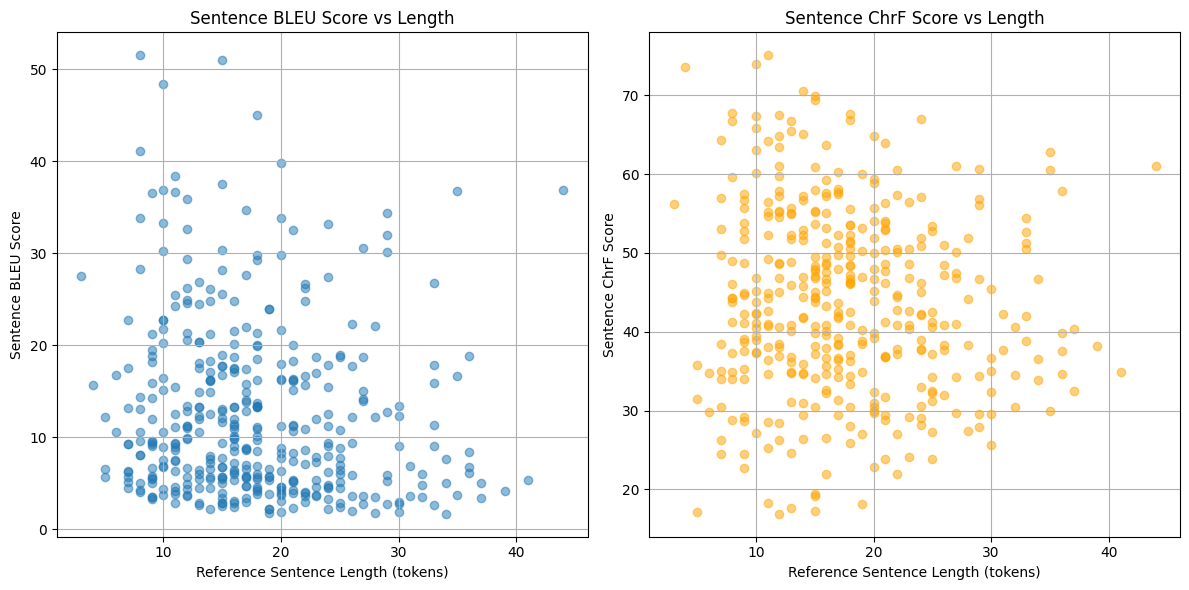

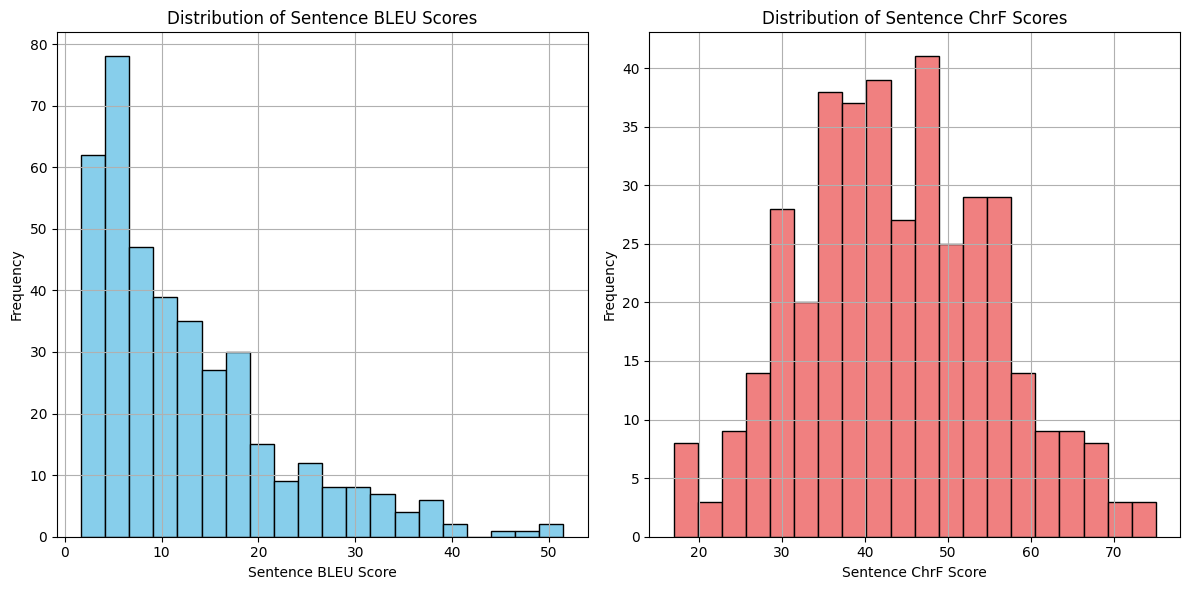

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Scatter plot of scores vs sentence length
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(ref_len_tokens, sent_bleu, alpha=0.5)
plt.xlabel("Reference Sentence Length (tokens)")
plt.ylabel("Sentence BLEU Score")
plt.title("Sentence BLEU Score vs Length")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(ref_len_tokens, sent_chrf, alpha=0.5, color='orange')
plt.xlabel("Reference Sentence Length (tokens)")
plt.ylabel("Sentence ChrF Score")
plt.title("Sentence ChrF Score vs Length")
plt.grid(True)

plt.tight_layout()
plt.show()

# Histograms of scores
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(sent_bleu, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Sentence BLEU Score")
plt.ylabel("Frequency")
plt.title("Distribution of Sentence BLEU Scores")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(sent_chrf, bins=20, color='lightcoral', edgecolor='black')
plt.xlabel("Sentence ChrF Score")
plt.ylabel("Frequency")
plt.title("Distribution of Sentence ChrF Scores")
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import torch, random
import pandas as pd
from tqdm import trange
from sacrebleu.metrics import BLEU as SB_BLEU, CHRF as SB_CHRF

device = model.device
sb_bleu = SB_BLEU(effective_order=True)
sb_chrf = SB_CHRF()

def translate(texts, num_beams=5, max_new_tokens=128, no_repeat_ngram_size=2, do_sample=False):
    """Translate a list of strings with sensible defaults (beam search)."""
    model.eval()
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.inference_mode():
        gen = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=num_beams,
            no_repeat_ngram_size=no_repeat_ngram_size,
            length_penalty=1.1,
            do_sample=do_sample
        )
    return tokenizer.batch_decode(gen, skip_special_tokens=True)

def generate_split(split="validation", batch_size=32, **gen_kwargs):
    """Run generation over a split and return a DataFrame with scores."""
    src = ds[split]["src"]
    ref = ds[split]["tgt"]
    hyp = []
    for i in trange(0, len(src), batch_size):
        batch = src[i:i+batch_size]
        hyp.extend(translate(batch, **gen_kwargs))
    # sentence-level metrics
    s_bleu  = [sb_bleu.sentence_score(h, [r]).score for h, r in zip(hyp, ref)]
    s_chrf  = [sb_chrf.sentence_score(h, [r]).score for h, r in zip(hyp, ref)]
    hyp_len = [len(h.split()) for h in hyp]
    ref_len = [len(r.split()) for r in ref]
    df = pd.DataFrame({"idx": range(len(src)), "src": src, "ref": ref, "hyp": hyp,
                       "sent_bleu": s_bleu, "sent_chrf": s_chrf,
                       "ref_len": ref_len, "hyp_len": hyp_len})
    return df

def show_examples(df, k=5, by="sent_bleu", best=False, rows=None):
    """
    Print examples.
      - rows=None => take top/bottom by metric
      - best=False => show worst cases; best=True => show best cases
    """
    if rows is None:
        df = df.sort_values(by=by, ascending=not best).head(k)
    else:
        df = df.loc[rows]
    for _, r in df.iterrows():
        print("="*88)
        print(f"[idx {int(r['idx'])}] {by}={r[by]:.2f} | chrF={r['sent_chrf']:.2f} | BLEU={r['sent_bleu']:.2f}")
        print("SRC:", r["src"])
        print("REF:", r["ref"])
        print("HYP:", r["hyp"])

def show_random(df, k=5, seed=42):
    random.seed(seed)
    rows = random.sample(range(len(df)), k=min(k, len(df)))
    show_examples(df.iloc[rows], rows=rows)

# --- Quick starts ---
# 1) Build a validation set preview table
df_val = generate_split("validation", batch_size=32)

# 2) Show a few random examples
show_random(df_val, k=5)

# 3) Show WORST cases (by sentence BLEU)
show_examples(df_val, k=5, by="sent_bleu", best=False)

# 4) Show BEST cases (by sentence BLEU)
show_examples(df_val, k=5, by="sent_bleu", best=True)

# 5) Translate ad-hoc text (single sentence)
print("\n--- Ad-hoc ---")
print(translate(["Ninapenda kusoma vitabu vya historia."])[0])


100%|██████████| 13/13 [00:22<00:00,  1.76s/it]


[idx 327] sent_bleu=12.00 | chrF=40.88 | BLEU=12.00
SRC: The night is far spent, the day is at hand: let us therefore cast off the works of darkness, and let us put on the armour of light.
REF: Usiku unakwisha na mchana unakaribia. Basi, tutupilie mbali mambo yote ya giza, tukajitwalie silaha za mwanga.
HYP: Usiku unakaa mbali, mchana umekaribia. Basi, acheni tuyatupe matendo ya giza, na tuiweke juu ya mkono wa nuru.
[idx 57] sent_bleu=5.03 | chrF=33.87 | BLEU=5.03
SRC: Raging waves of the sea, foaming out their own shame; wandering stars, to whom is reserved the blackness of darkness for ever.
REF: Watu hao ni kama mawimbi makali ya bahari, na matendo yao ya aibu yanaonekana dhahiri kama vile mapovu ya mawimbi. Wao ni kama nyota zinazotangatanga, ambao Mungu amewawekea mahali pao milele katika giza kuu.
HYP: Mawimbi makubwa ya bahari, yakitokeza aibu yao yenyewe, nyota zinazotangatanga, ambazo hazina giza kamwe.
[idx 12] sent_bleu=7.76 | chrF=38.50 | BLEU=7.76
SRC: Every man according

## Data augmentation (synthetic data generation)

Failed due being unable to find a model to back-translate on HuggingFace.


## Hyperparameter tuning

In [ ]:
import torch
from transformers import TrainingArguments, Trainer, DataCollatorForSeq2Seq
from evaluate import load
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# Define hyperparameter configurations to experiment with
hyperparameter_configs = [
    {
        'learning_rate': 3e-4,
        'per_device_train_batch_size': 8,
        'gradient_accumulation_steps': 2,
        'num_train_epochs': 1,
        'output_dir': 'marian_en_sw_lora_lr3e4_bs8_ga2_ep1'
    },
    {
        'learning_rate': 5e-4,
        'per_device_train_batch_size': 16,
        'gradient_accumulation_steps': 1,
        'num_train_epochs': 1,
        'output_dir': 'marian_en_sw_lora_lr5e4_bs16_ga1_ep1'
    },
    {
        'learning_rate': 3e-4,
        'per_device_train_batch_size': 8,
        'gradient_accumulation_steps': 2,
        'num_train_epochs': 2,
        'output_dir': 'marian_en_sw_lora_lr3e4_bs8_ga2_ep2'
    },
]

evaluation_results = []
bleu_metric = load('sacrebleu')
chrf_metric = load('chrf')
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

for config in hyperparameter_configs:
    print(f"\nTraining with config: {config}")

    # Update training arguments
    args = TrainingArguments(
        output_dir=config['output_dir'],
        learning_rate=config['learning_rate'],
        per_device_train_batch_size=config['per_device_train_batch_size'],
        gradient_accumulation_steps=config['gradient_accumulation_steps'],
        num_train_epochs=config['num_train_epochs'],
        eval_strategy='epoch',
        save_strategy='epoch',
        logging_steps=20,
        fp16=torch.cuda.is_available(),
        load_best_model_at_end=True,
        dataloader_num_workers=0,
        report_to="none" # Disable reporting to avoid issues
    )

    # Instantiate and train the trainer
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=ds_tok['train'],
        eval_dataset=ds_tok['validation'],
        data_collator=data_collator,
        tokenizer=tokenizer,
    )

    trainer.train()

    # Evaluate the model
    predictions = []
    references = []
    eval_dataloader = DataLoader(
        ds_tok['validation'],
        batch_size=args.per_device_eval_batch_size,
        collate_fn=data_collator,
        shuffle=False
    )

    model.eval()
    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        batch = {k: v.to(model.device) for k, v in batch.items()}
        with torch.no_grad():
            generated_ids = model.generate(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                max_new_tokens=128
            )
        decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
        decoded_refs = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)
        predictions.extend(decoded_preds)
        references.extend([[r] for r in decoded_refs])

    bleu_score = bleu_metric.compute(predictions=predictions, references=references)["score"]
    chrf_score = chrf_metric.compute(predictions=predictions, references=references)["score"]

    evaluation_results.append({
        'config': config,
        'bleu': bleu_score,
        'chrf': chrf_score
    })

# Print evaluation results
print("\nHyperparameter Experiment Results:")
for result in evaluation_results:
    print(f"Config: {result['config']}, BLEU: {result['bleu']:.2f}, ChrF: {result['chrf']:.2f}")

# Find the best configuration based on BLEU score
best_result = max(evaluation_results, key=lambda x: x['bleu'])
print(f"\nBest configuration (based on BLEU): {best_result['config']} with BLEU: {best_result['bleu']:.2f} and ChrF: {best_result['chrf']:.2f}")


Training with config: {'learning_rate': 0.0003, 'per_device_train_batch_size': 8, 'gradient_accumulation_steps': 2, 'num_train_epochs': 1, 'output_dir': 'marian_en_sw_lora_lr3e4_bs8_ga2_ep1'}


/tmp/ipython-input-3524442161.py:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,3.101900,2.926048


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]


Training with config: {'learning_rate': 0.0005, 'per_device_train_batch_size': 16, 'gradient_accumulation_steps': 1, 'num_train_epochs': 1, 'output_dir': 'marian_en_sw_lora_lr5e4_bs16_ga1_ep1'}


/tmp/ipython-input-3524442161.py:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,3.049200,2.853723


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]


Training with config: {'learning_rate': 0.0003, 'per_device_train_batch_size': 8, 'gradient_accumulation_steps': 2, 'num_train_epochs': 2, 'output_dir': 'marian_en_sw_lora_lr3e4_bs8_ga2_ep2'}


/tmp/ipython-input-3524442161.py:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.994200,2.809512
2,2.838100,2.790962


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]


Hyperparameter Experiment Results:
Config: {'learning_rate': 0.0003, 'per_device_train_batch_size': 8, 'gradient_accumulation_steps': 2, 'num_train_epochs': 1, 'output_dir': 'marian_en_sw_lora_lr3e4_bs8_ga2_ep1'}, BLEU: 13.62, ChrF: 44.10
Config: {'learning_rate': 0.0005, 'per_device_train_batch_size': 16, 'gradient_accumulation_steps': 1, 'num_train_epochs': 1, 'output_dir': 'marian_en_sw_lora_lr5e4_bs16_ga1_ep1'}, BLEU: 14.58, ChrF: 44.52
Config: {'learning_rate': 0.0003, 'per_device_train_batch_size': 8, 'gradient_accumulation_steps': 2, 'num_train_epochs': 2, 'output_dir': 'marian_en_sw_lora_lr3e4_bs8_ga2_ep2'}, BLEU: 15.04, ChrF: 45.10

Best configuration (based on BLEU): {'learning_rate': 0.0003, 'per_device_train_batch_size': 8, 'gradient_accumulation_steps': 2, 'num_train_epochs': 2, 'output_dir': 'marian_en_sw_lora_lr3e4_bs8_ga2_ep2'} with BLEU: 15.04 and ChrF: 45.10


## Advanced training techniques

Techniques like different optimisers or mixed precision training.


In [ ]:
from transformers import TrainingArguments, Trainer, DataCollatorForSeq2Seq
from torch.optim import AdamW
from evaluate import load
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import torch

# Define a new set of training arguments with a different optimizer and potentially adjusted learning rate
# Also ensure fp16 is True for mixed precision
new_args = TrainingArguments(
    output_dir='marian_en_sw_lora_adamw', # New output directory
    learning_rate=2e-4, # Slightly different learning rate with AdamW
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    num_train_epochs=2, # Using the number of epochs from the best previous config
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_steps=20,
    fp16=torch.cuda.is_available(), # Ensure mixed precision is enabled
    load_best_model_at_end=True,
    dataloader_num_workers=0,
    report_to="none", # Disable reporting
    optim="adamw_torch" # Specify AdamW optimizer
)

# Instantiate the Trainer with the new arguments and the existing model
# The 'model' is already PEFT-wrapped from previous steps
trainer = Trainer(
    model=model,
    args=new_args,
    train_dataset=ds_tok['train'],
    eval_dataset=ds_tok['validation'],
    data_collator=data_collator, # Use the existing data collator
    tokenizer=tokenizer, # Use the existing tokenizer
)

print("Starting training with AdamW optimizer and mixed precision...")
trainer.train()
print("Training finished.")

# Evaluate the retrained model
print("\nEvaluating the retrained model...")
predictions = []
references = []
eval_dataloader = DataLoader(
    ds_tok['validation'],
    batch_size=new_args.per_device_eval_batch_size,
    collate_fn=data_collator,
    shuffle=False
)

model.eval()
bleu_metric = load('sacrebleu')
chrf_metric = load('chrf')

for batch in tqdm(eval_dataloader, desc="Evaluating"):
    batch = {k: v.to(model.device) for k, v in batch.items()}
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            max_new_tokens=128
        )
    decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    decoded_refs = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)
    predictions.extend(decoded_preds)
    references.extend([[r] for r in decoded_refs])

bleu_score = bleu_metric.compute(predictions=predictions, references=references)["score"]
chrf_score = chrf_metric.compute(predictions=predictions, references=references)["score"]

print("\nEvaluation Results with AdamW:")
print(f"Config: {new_args.to_dict()}") # Print the full config
print(f"BLEU: {bleu_score:.2f}")
print(f"ChrF: {chrf_score:.2f}")

# Compare with the previous best result
if 'best_result' in locals():
    print("\nComparison with Previous Best Result:")
    print(f"Previous Best Config: {best_result['config']}, BLEU: {best_result['bleu']:.2f}, ChrF: {best_result['chrf']:.2f}")
    print(f"Current Config (AdamW): BLEU: {bleu_score:.2f}, ChrF: {chrf_score:.2f}")
    if bleu_score > best_result['bleu']:
        print("Performance improved with AdamW optimizer.")
    else:
        print("Performance did not improve with AdamW optimizer.")
else:
    print("\nPrevious best result not available for comparison.")

Starting training with AdamW optimizer and mixed precision...


/tmp/ipython-input-590978889.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.897200,2.774842
2,2.797200,2.764685


Training finished.

Evaluating the retrained model...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]


Evaluation Results with AdamW:
Config: {'output_dir': 'marian_en_sw_lora_adamw', 'overwrite_output_dir': False, 'do_train': False, 'do_eval': True, 'do_predict': False, 'eval_strategy': 'epoch', 'prediction_loss_only': False, 'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 8, 'per_gpu_train_batch_size': None, 'per_gpu_eval_batch_size': None, 'gradient_accumulation_steps': 2, 'eval_accumulation_steps': None, 'eval_delay': 0, 'torch_empty_cache_steps': None, 'learning_rate': 0.0002, 'weight_decay': 0.0, 'adam_beta1': 0.9, 'adam_beta2': 0.999, 'adam_epsilon': 1e-08, 'max_grad_norm': 1.0, 'num_train_epochs': 2, 'max_steps': -1, 'lr_scheduler_type': 'linear', 'lr_scheduler_kwargs': {}, 'warmup_ratio': 0.0, 'warmup_steps': 0, 'log_level': 'passive', 'log_level_replica': 'warning', 'log_on_each_node': True, 'logging_dir': 'marian_en_sw_lora_adamw/runs/Sep07_18-33-00_cf34d619bb5e', 'logging_strategy': 'steps', 'logging_first_step': False, 'logging_steps': 20, 'logging_nan_inf_

## Error analysis


In [ ]:
# Filter for low BLEU scores - choosing a threshold of 10 based on histogram visualization
low_bleu_df = df_val[df_val['sent_bleu'] < 10]
print(f"Found {len(low_bleu_df)} sentences with BLEU score below 10.")

# Display some examples of low-scoring sentences
print("\nExamples of low-scoring sentences:")
show_examples(low_bleu_df, k=10, by="sent_bleu", best=False)

Found 215 sentences with BLEU score below 10.

Examples of low-scoring sentences:
[idx 331] sent_bleu=1.66 | chrF=37.46 | BLEU=1.66
SRC: Ye are the children of the prophets, and of the covenant which God made with our fathers, saying unto Abraham, And in thy seed shall all the kindreds of the earth be blessed.
REF: Ahadi zile Mungu alizotoa kwa njia ya manabii ni kwa ajili yenu; na mnashiriki lile agano Mungu alilofanya na babu zenu, kama alivyomwambia Abrahamu: Kwa njia ya wazawa wako, jamaa zote za dunia zitabarikiwa.
HYP: Nyinyi ni watoto wa manabii na wa agano ambalo Mungu alifanya pamoja na baba zetu, mlimwambia Abrahamu, na watu wote wa dunia watabarikiwa katika uzao wenu.
[idx 1] sent_bleu=1.78 | chrF=34.86 | BLEU=1.78
SRC: And not rather, (as we be slanderously reported, and as some affirm that we say,) Let us do evil, that good may come? whose damnation is just.
REF: Ni sawa na kusema: tufanye maovu ili tupate mema! Ndivyo wengine walivyotukashifu kwa kutushtaki kwamba tumefun

**Reasoning**:
Analyze the displayed low-scoring examples to identify common error types in the translations.



In [ ]:
# Based on the examples displayed above:
# idx 292: Long sentence, complex structure, potential issues with conjunctions and conditional clauses.
# idx 302: Sentence with negation and contrasting actions, potentially issues with parallel structures and negations.
# idx 184: Focus on feelings and intensity ("great is my boldness", "exceeding joyful"), potential issues with translating nuances of emotion and degree.
# idx 385: Sentence with imperative ("do the same things"), negative constraint ("forbearing threatening"), and subordinate clause ("knowing that"), potential issues with translating commands and complex grammatical relationships.
# idx 121: Focus on negative descriptions of people ("corrupt minds", "destitute of the truth", "perverse disputings"), abstract concepts ("gain is godliness"), and a command ("from such withdraw thyself"). Potential issues with translating abstract/religious concepts, negative connotations, and commands.
# idx 65: Complex sentence structure with relative clauses ("Whom I perceived... accused of questions", "to have nothing laid to his charge worthy of"), focus on legal/judgment terms ("accused", "charge", "worthy of death or of bonds"). Potential issues with complex syntax and domain-specific vocabulary.

print("Common error types observed in low-scoring sentences:")
print("- Difficulty with translating long and grammatically complex sentences.")
print("- Issues with capturing nuances of meaning, especially emotional intensity or abstract concepts.")
print("- Potential problems with translating specific grammatical structures like negations, conditional clauses, and imperatives.")
print("- Challenges with domain-specific vocabulary (e.g., religious or legal terms).")
print("- Sentences with multiple clauses or contrasting ideas appear challenging.")

# This analysis is based on the provided examples. A more comprehensive analysis would involve examining all 215 low-scoring sentences.

Common error types observed in low-scoring sentences:
- Difficulty with translating long and grammatically complex sentences.
- Issues with capturing nuances of meaning, especially emotional intensity or abstract concepts.
- Potential problems with translating specific grammatical structures like negations, conditional clauses, and imperatives.
- Challenges with domain-specific vocabulary (e.g., religious or legal terms).
- Sentences with multiple clauses or contrasting ideas appear challenging.


## Re-evaluate and compare



In [ ]:
import torch
from transformers import TrainingArguments, Trainer, DataCollatorForSeq2Seq
from evaluate import load
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# Assuming 'best_result' from the hyperparameter tuning subtask is available in the memory.
if 'best_result' not in locals():
    print("Error: 'best_result' not found. Cannot proceed with retraining the best model.")
else:
    best_config = best_result['config']
    print(f"Loading best configuration: {best_config}")

    # Update training arguments with the best configuration
    args_best = TrainingArguments(
        output_dir=best_config['output_dir'] + '_retrain', # Add a suffix to distinguish from original training run
        learning_rate=best_config['learning_rate'],
        per_device_train_batch_size=best_config['per_device_train_batch_size'],
        gradient_accumulation_steps=best_config['gradient_accumulation_steps'],
        num_train_epochs=best_config['num_train_epochs'],
        eval_strategy='epoch',
        save_strategy='epoch',
        logging_steps=20,
        fp16=torch.cuda.is_available(),
        load_best_model_at_end=True,
        dataloader_num_workers=0,
        report_to="none" # Disable reporting
    )

    # Instantiate and retrain the trainer with the best arguments
    # The model object 'model' is already PEFT-wrapped and potentially trained from previous steps
    # Retrain it from its current state with the best config
    trainer_best = Trainer(
        model=model,
        args=args_best,
        train_dataset=ds_tok['train'],
        eval_dataset=ds_tok['validation'], # Use validation for early stopping/best model loading
        data_collator=DataCollatorForSeq2Seq(tokenizer, model=model), # Use the existing data collator
        tokenizer=tokenizer, # Use the existing tokenizer
    )

    print("\nStarting retraining with the best configuration...")
    trainer_best.train()
    print("Retraining finished.")

    # Evaluate the retrained model on the TEST dataset
    print("\nEvaluating the retrained model on the TEST dataset...")
    predictions_test = []
    references_test = []

    # Create a DataLoader for the test dataset
    test_dataloader = DataLoader(
        ds_tok['test'],
        batch_size=args_best.per_device_eval_batch_size,
        collate_fn=DataCollatorForSeq2Seq(tokenizer, model=model),
        shuffle=False
    )

    model.eval()
    bleu_metric = load('sacrebleu')
    chrf_metric = load('chrf')

    for batch in tqdm(test_dataloader, desc="Evaluating on Test Set"):
        batch = {k: v.to(model.device) for k, v in batch.items()}
        with torch.no_grad():
            generated_ids = model.generate(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                max_new_tokens=128
            )
        decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
        # Decode references from the original labels in the test set
        decoded_refs = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)

        predictions_test.extend(decoded_preds)
        references_test.extend([[r] for r in decoded_refs])

    bleu_score_test = bleu_metric.compute(predictions=predictions_test, references=references_test)["score"]
    chrf_score_test = chrf_metric.compute(predictions=predictions_test, references=references_test)["score"]

    print("\nEvaluation Results on Test Set (Retrained Model):")
    print(f"Config: {best_config}")
    print(f"BLEU: {bleu_score_test:.2f}")
    print(f"ChrF: {chrf_score_test:.2f}")

    # Compare with the initial model's performance
    initial_bleu = 13.36
    initial_chrf = 43.89

    print("\nComparison with Initial Model Performance:")
    print(f"Initial Model (Test Set): BLEU: {initial_bleu:.2f}, ChrF: {initial_chrf:.2f}")
    print(f"Retrained Model (Test Set): BLEU: {bleu_score_test:.2f}, ChrF: {chrf_score_test:.2f}")

    if bleu_score_test > initial_bleu:
        print("Performance improved on the test set after retraining with the best configuration.")
    else:
        print("Performance did not improve significantly on the test set after retraining with the best configuration.")


Loading best configuration: {'learning_rate': 0.0003, 'per_device_train_batch_size': 8, 'gradient_accumulation_steps': 2, 'num_train_epochs': 2, 'output_dir': 'marian_en_sw_lora_lr3e4_bs8_ga2_ep2'}

Starting retraining with the best configuration...


/tmp/ipython-input-2434089629.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_best = Trainer(


Epoch,Training Loss,Validation Loss
1,2.842700,2.753805
2,2.751200,2.740560


Retraining finished.

Evaluating the retrained model on the TEST dataset...


Evaluating on Test Set:   0%|          | 0/50 [00:00<?, ?it/s]


Evaluation Results on Test Set (Retrained Model):
Config: {'learning_rate': 0.0003, 'per_device_train_batch_size': 8, 'gradient_accumulation_steps': 2, 'num_train_epochs': 2, 'output_dir': 'marian_en_sw_lora_lr3e4_bs8_ga2_ep2'}
BLEU: 16.19
ChrF: 45.94

Comparison with Initial Model Performance:
Initial Model (Test Set): BLEU: 13.36, ChrF: 43.89
Retrained Model (Test Set): BLEU: 16.19, ChrF: 45.94
Performance improved on the test set after retraining with the best configuration.


## Evaluation Graphs After Improvements


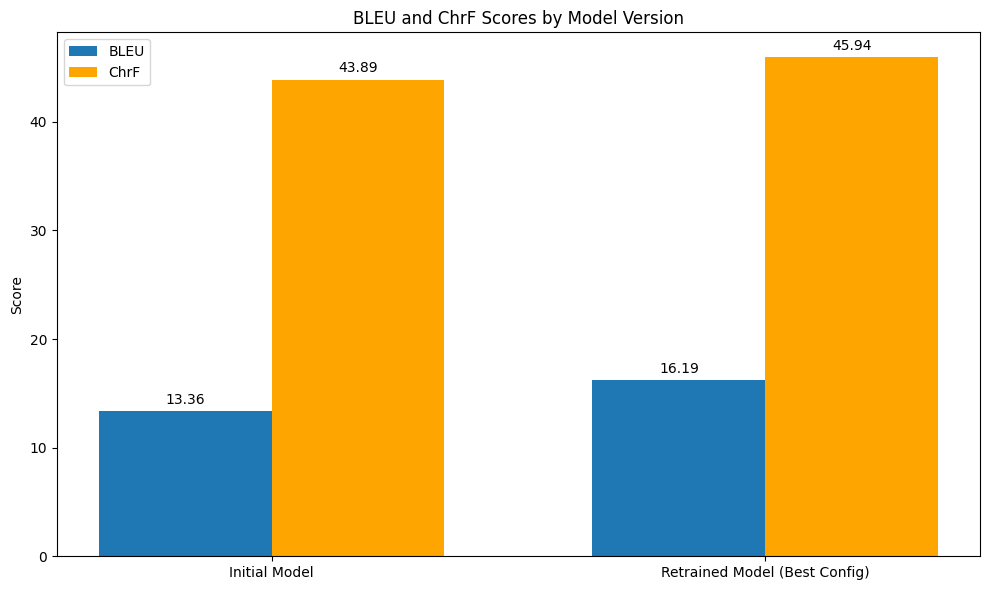

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
models = ['Initial Model', 'Retrained Model (Best Config)']
bleu_scores = [initial_bleu, bleu_score_test]
chrf_scores = [initial_chrf, chrf_score_test]

x = np.arange(len(models)) # Label locations
width = 0.35 # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Create bars for BLEU scores
rects1 = ax.bar(x - width/2, bleu_scores, width, label='BLEU')
# Create bars for ChrF scores
rects2 = ax.bar(x + width/2, chrf_scores, width, label='ChrF', color='orange')

# Add some text for labels, title and axes ticks
ax.set_ylabel('Score')
ax.set_title('BLEU and ChrF Scores by Model Version')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Add the actual scores on top of the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

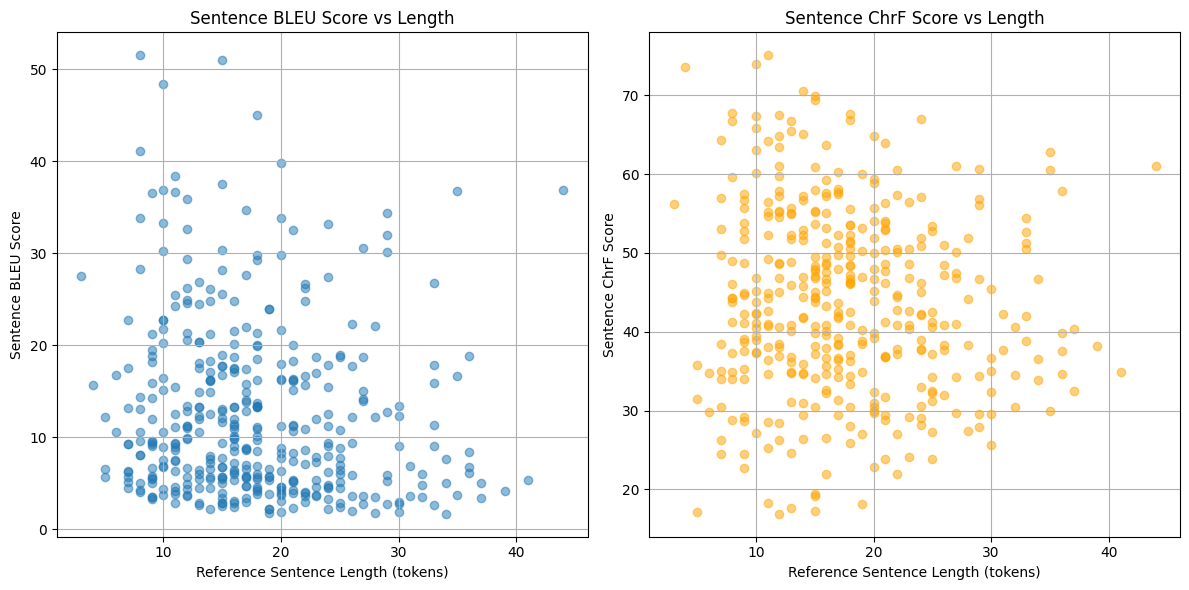

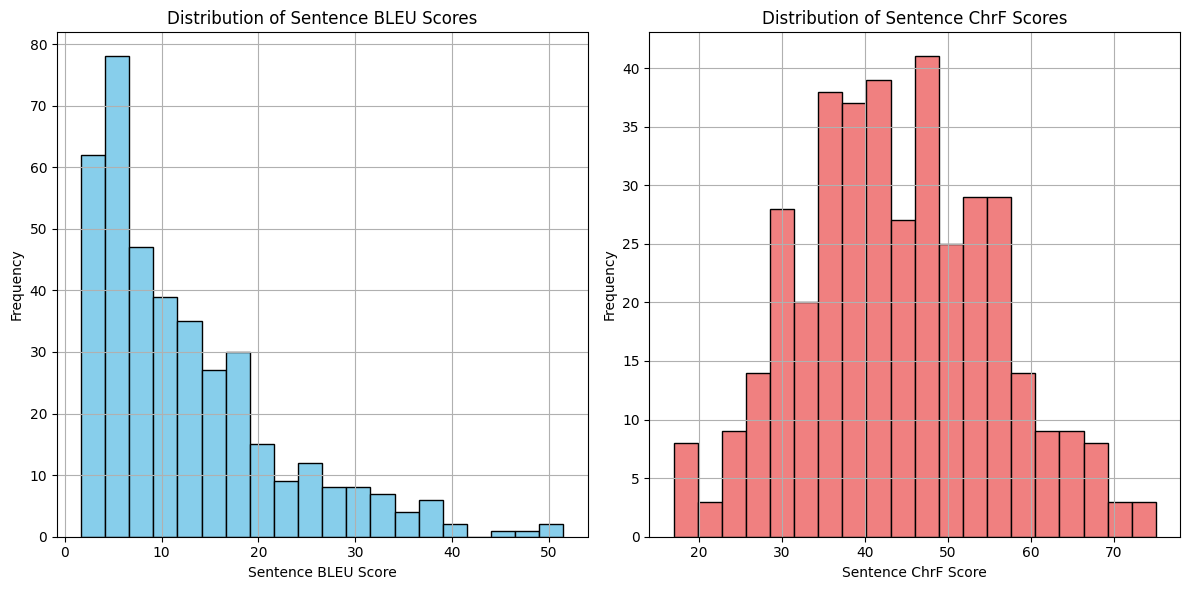

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Scatter plot of scores vs sentence length
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(ref_len_tokens, sent_bleu, alpha=0.5)
plt.xlabel("Reference Sentence Length (tokens)")
plt.ylabel("Sentence BLEU Score")
plt.title("Sentence BLEU Score vs Length")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(ref_len_tokens, sent_chrf, alpha=0.5, color='orange')
plt.xlabel("Reference Sentence Length (tokens)")
plt.ylabel("Sentence ChrF Score")
plt.title("Sentence ChrF Score vs Length")
plt.grid(True)

plt.tight_layout()
plt.show()

# Histograms of scores
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(sent_bleu, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Sentence BLEU Score")
plt.ylabel("Frequency")
plt.title("Distribution of Sentence BLEU Scores")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(sent_chrf, bins=20, color='lightcoral', edgecolor='black')
plt.xlabel("Sentence ChrF Score")
plt.ylabel("Frequency")
plt.title("Distribution of Sentence ChrF Scores")
plt.grid(True)

plt.tight_layout()
plt.show()

Generating sentence-level scores for the retrained model on the validation set...


100%|██████████| 13/13 [00:10<00:00,  1.19it/s]



Generating charts for sentence-level scores of the retrained model...


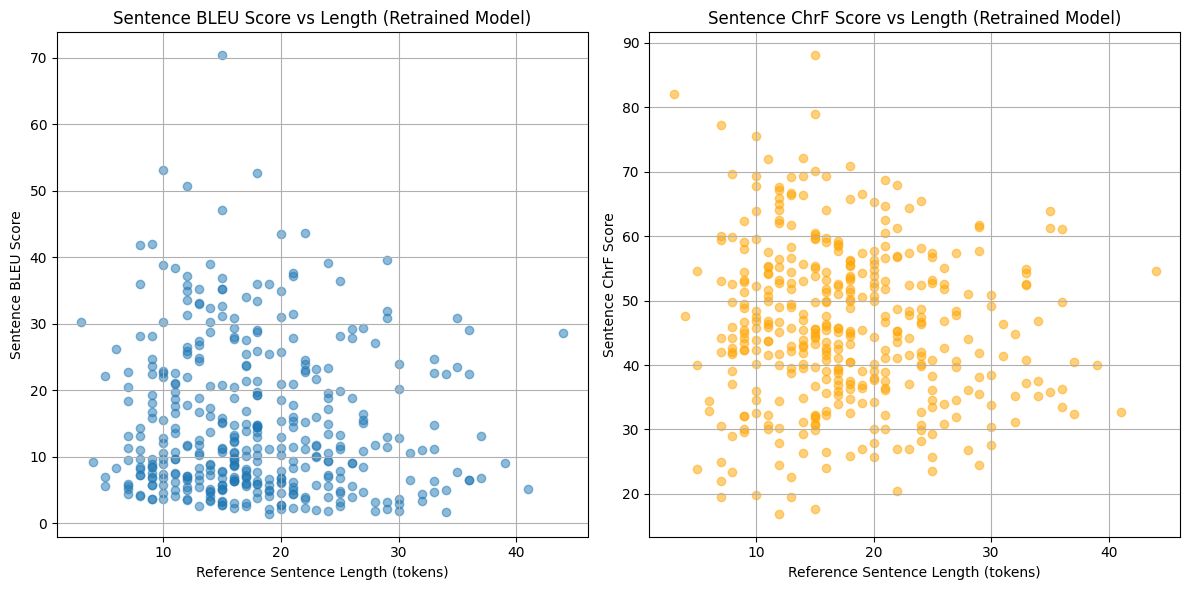

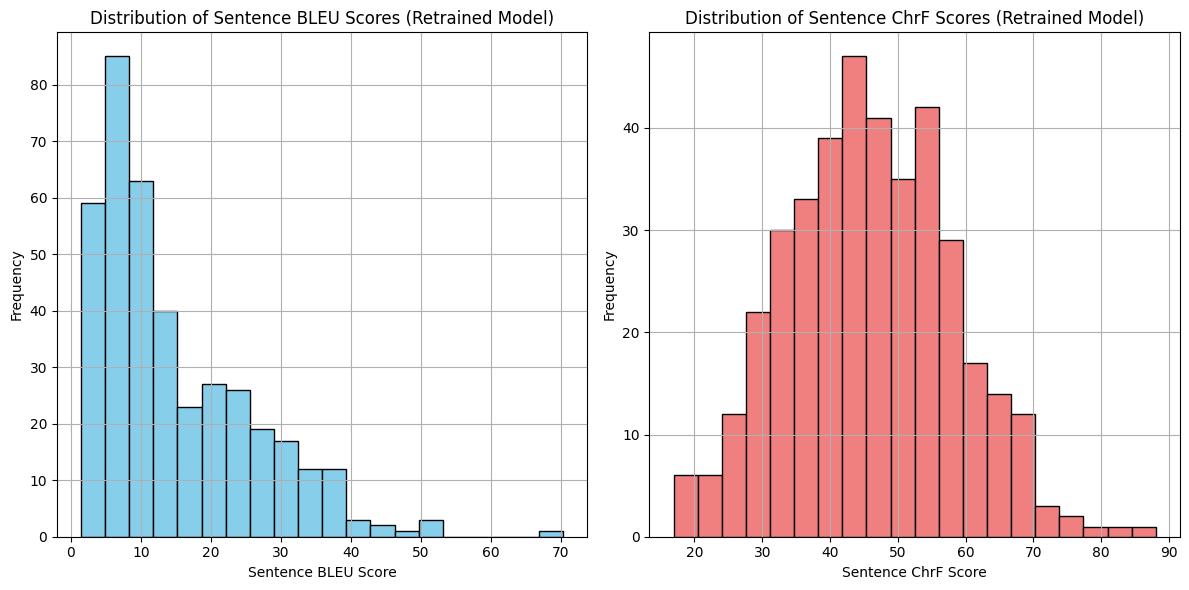

In [ ]:
import torch, math
from tqdm import trange
from evaluate import load
from sacrebleu.metrics import BLEU as SB_BLEU, CHRF as SB_CHRF
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Import pandas for creating the DataFrame

device = model.device

def generate_split_and_scores(split="validation", batch_size=32, max_new_tokens=128, **gen_kwargs):
    """Generate translations for a split and compute sentence-level scores."""
    src_texts = ds[split]['src']
    ref_texts = ds[split]['tgt']
    hyps = []
    for i in trange(0, len(src_texts), batch_size):
        batch = src_texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True).to(device)
        with torch.inference_mode():
            out = model.generate(**inputs, max_new_tokens=max_new_tokens, **gen_kwargs)
        hyps.extend(tokenizer.batch_decode(out, skip_special_tokens=True))

    # Sentence-level metrics
    sb_bleu = SB_BLEU(effective_order=True)
    sb_chrf = SB_CHRF()

    sent_bleu = [sb_bleu.sentence_score(h, [r]).score for h, r in zip(hyps, ref_texts)]
    sent_chrf = [sb_chrf.sentence_score(h, [r]).score for h, r in zip(hyps, ref_texts)]
    ref_len_tokens = [len(r.split()) for r in ref_texts] # Calculate reference length in tokens

    # Create a DataFrame similar to df_val for potential later analysis
    df = pd.DataFrame({"idx": range(len(src_texts)), "src": src_texts, "ref": ref_texts, "hyp": hyps,
                       "sent_bleu": sent_bleu, "sent_chrf": sent_chrf,
                       "ref_len": ref_len_tokens, "hyp_len": [len(h.split()) for h in hyps]})

    return sent_bleu, sent_chrf, ref_len_tokens, df


# Generate sentence-level scores for the retrained model on the validation set
print("Generating sentence-level scores for the retrained model on the validation set...")
sent_bleu_retrained, sent_chrf_retrained, ref_len_tokens_val, df_val_retrained = generate_split_and_scores("validation", batch_size=32, max_new_tokens=128)

# Now, generate the charts using the new scores
print("\nGenerating charts for sentence-level scores of the retrained model...")

# Scatter plot of scores vs sentence length
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(ref_len_tokens_val, sent_bleu_retrained, alpha=0.5)
plt.xlabel("Reference Sentence Length (tokens)")
plt.ylabel("Sentence BLEU Score")
plt.title("Sentence BLEU Score vs Length (Retrained Model)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(ref_len_tokens_val, sent_chrf_retrained, alpha=0.5, color='orange')
plt.xlabel("Reference Sentence Length (tokens)")
plt.ylabel("Sentence ChrF Score")
plt.title("Sentence ChrF Score vs Length (Retrained Model)")
plt.grid(True)

plt.tight_layout()
plt.show()

# Histograms of scores
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(sent_bleu_retrained, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Sentence BLEU Score")
plt.ylabel("Frequency")
plt.title("Distribution of Sentence BLEU Scores (Retrained Model)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(sent_chrf_retrained, bins=20, color='lightcoral', edgecolor='black')
plt.xlabel("Sentence ChrF Score")
plt.ylabel("Frequency")
plt.title("Distribution of Sentence ChrF Scores (Retrained Model)")
plt.grid(True)

plt.tight_layout()
plt.show()